In [1]:
# Libraries
import numpy as np
import pandas as pd
from sklearn import tree
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [2]:
#re-create a hypothetical dataset
data = {
        'Day':["1","2","3","4","5"],
        'Temperature': ["Cold","Hot","Cold","Hot","Hot"],
        'Humidity': ["Normal","Normal","Normal","High","High"],
        'Outlook': ["Rain","Rain","Sunny","Sunny","Rain"], 
        'Wind': ["Strong","Weak","Weak","Weak","Weak"],
        'Play Golf': ["No", "No", "Yes", "Yes", "Yes"]
}  

# Transform dataset into a DataFrame df using pandas library
#  Use the "Day" variable as an index
df = pd.DataFrame(data).set_index("Day")

# print the output
df

,Temperature,Humidity,Outlook,Wind,Play Golf
Day,,,,,
1,Cold,Normal,Rain,Strong,No
2,Hot,Normal,Rain,Weak,No
3,Cold,Normal,Sunny,Weak,Yes
4,Hot,High,Sunny,Weak,Yes
5,Hot,High,Rain,Weak,Yes


# 1. Bagging

Bagging has two components:
1. Learn many different decision trees, each on a randomized version of the training data
2. Combine the predictions with averaging to make a final prediction

### Bootstrapping

Bootstrapping is a way to compute a randomized dataset from a finite dataset.  It does so by choosing data points uniformly at random with replacement.

- We first build a simple function to do bootstrap sampling
- We then show how to use bootstrapping to draw a random sample of the dataset above

In [3]:
import random

def bootstrap_sample_index(n, random_seed=0):
    # n is the length of the list
    # random_seed: ensures that pseudo-random sequence is the same each time you use the same seed.
    random.seed(random_seed)
    return [random.randint(0, n-1) for _ in range(n)]

take = bootstrap_sample_index(n=5, random_seed=0)
take

[3, 3, 0, 2, 4]

In [4]:
# Make bootstrapped dataset
#  (Note how Day = 1 + integer index)
df.iloc[take]

,Temperature,Humidity,Outlook,Wind,Play Golf
Day,,,,,
4,Hot,High,Sunny,Weak,Yes
4,Hot,High,Sunny,Weak,Yes
1,Cold,Normal,Rain,Strong,No
3,Cold,Normal,Sunny,Weak,Yes
5,Hot,High,Rain,Weak,Yes


### Data Preparation

We first prepare our data for learning our ensemble.  We perform these two tasks:
- Split the data into features and prediction
- Encode Categorical features as dummy variables

In [5]:
# Split data into X and y
X_raw = df.drop("Play Golf", axis="columns")
y = df["Play Golf"]

display(X_raw, y)

,Temperature,Humidity,Outlook,Wind
Day,,,,
1,Cold,Normal,Rain,Strong
2,Hot,Normal,Rain,Weak
3,Cold,Normal,Sunny,Weak
4,Hot,High,Sunny,Weak
5,Hot,High,Rain,Weak


Day
1     No
2     No
3    Yes
4    Yes
5    Yes
Name: Play Golf, dtype: object

In [6]:
# Encode categorical
X = pd.get_dummies(X_raw)
X

,Temperature_Cold,Temperature_Hot,Humidity_High,Humidity_Normal,Outlook_Rain,Outlook_Sunny,Wind_Strong,Wind_Weak
Day,,,,,,,,
1,1,0,0,1,1,0,1,0
2,0,1,0,1,1,0,0,1
3,1,0,0,1,0,1,0,1
4,0,1,1,0,0,1,0,1
5,0,1,1,0,1,0,0,1


## Ensemble Learning

We will now build our ensemble.
For each tree in our ensemble we must do the following two steps
1. Bootstrap sample dataset and display
2. Learn decision tree and display

Below is a function that does these two things

In [7]:
def bootstrap_sample_learn_tree(X, y, X_raw, random_seed, just_return_classifier=False):
    # 1. Make bootstrap sampled dataset
    take = bootstrap_sample_index(n=len(y), random_seed=random_seed)
    X_boot = X.iloc[take]
    y_boot = y.iloc[take]
    X_raw_boot = X_raw.iloc[take]  # used just for display, not learning
    
    # 2. Learn a decision tree
    #  Set up learning hyper-parameters
    clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=1)
    #  Actually learn
    clf.fit(X_boot, y_boot)
    if just_return_classifier:
        return clf
    else:
        # return everything
        #  Make a plot
        fig_tree = tree.plot_tree(
            clf,
            feature_names=X_boot.columns,
            class_names=['NO', 'YES'],
            filled=True
        )
        return take, X_boot, y_boot, X_raw_boot, clf, fig_tree

#### Ensemble Base Learner 1

We now build an actual ensemble.  We select a random dataset by setting the random_seed parameter, in this case to 0.

[3, 3, 0, 2, 4]

,Temperature,Humidity,Outlook,Wind
Day,,,,
4,Hot,High,Sunny,Weak
4,Hot,High,Sunny,Weak
1,Cold,Normal,Rain,Strong
3,Cold,Normal,Sunny,Weak
5,Hot,High,Rain,Weak


Day
4    Yes
4    Yes
1     No
3    Yes
5    Yes
Name: Play Golf, dtype: object

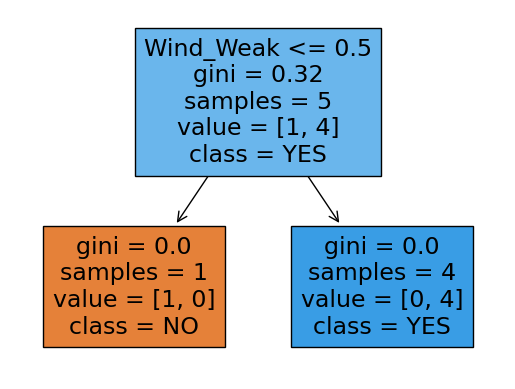

In [8]:
# First create a random dataset
take_1, X_1, y_1, X_raw_1, clf_1, fig_tree_1 = bootstrap_sample_learn_tree(X, y, X_raw, random_seed=0)
display(take_1, X_raw_1, y_1)

#### Ensemble Base Learner 2

Build another base learner with a new random data sample, by setting random_seed=1

[1, 4, 0, 2, 0]

,Temperature,Humidity,Outlook,Wind
Day,,,,
2,Hot,Normal,Rain,Weak
5,Hot,High,Rain,Weak
1,Cold,Normal,Rain,Strong
3,Cold,Normal,Sunny,Weak
1,Cold,Normal,Rain,Strong


Day
2     No
5    Yes
1     No
3    Yes
1     No
Name: Play Golf, dtype: object

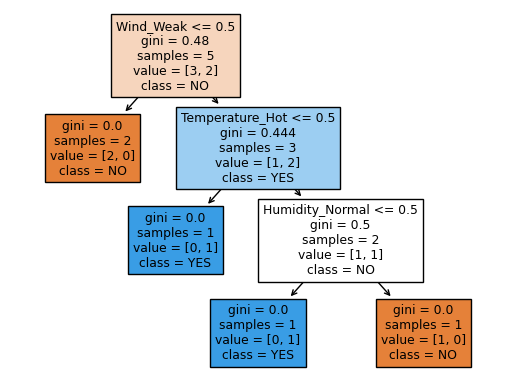

In [9]:
# First create a random dataset
take_2, X_2, y_2, X_raw_2, clf_2, fig_tree_2 = bootstrap_sample_learn_tree(X, y, X_raw, random_seed=1)
display(take_2, X_raw_2, y_2)

#### Ensemble Base Learner 3

Build another base learner with a new random data sample, by setting random_seed=2

[0, 0, 0, 2, 1]

,Temperature,Humidity,Outlook,Wind
Day,,,,
1,Cold,Normal,Rain,Strong
1,Cold,Normal,Rain,Strong
1,Cold,Normal,Rain,Strong
3,Cold,Normal,Sunny,Weak
2,Hot,Normal,Rain,Weak


Day
1     No
1     No
1     No
3    Yes
2     No
Name: Play Golf, dtype: object

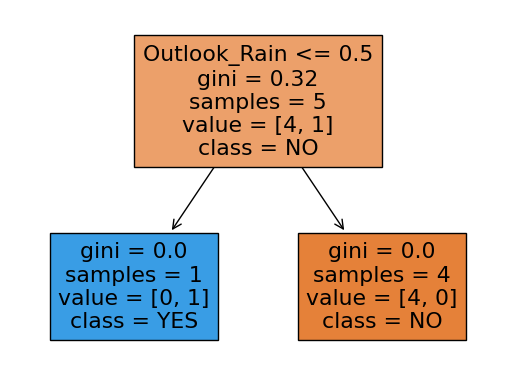

In [10]:
# First create a random dataset
take_3, X_3, y_3, X_raw_3, clf_3, fig_tree_3= bootstrap_sample_learn_tree(X, y, X_raw, random_seed=2)
display(take_3, X_raw_3, y_3)

### Combine

We now have a set of three decision trees, we combine their predictions

In [11]:
# --- todo:  which point to test on? ----
# #re-create a hypothetical dataset
# data_test = {
#         'Day':["100"],
#         'Temperature': ["Hot"],
#         'Humidity': ["High"],
#         'Outlook': ["Sunny"],
#         'Wind': ["Strong"],
#         'Play Golf': ["No"],
# }

# # Transform dataset into a DataFrame df using pandas library
# #  Use the "Day" variable as an index
# df_test = pd.DataFrame(data_test).set_index("Day")  

# # print the output
# X_raw_test = df_test.copy()
# y_test = X_raw_test.pop("Play Golf")
# X_test = pd.get_dummies(X_raw_test)
# display(X_test)

# display(X_raw_test, y_test)

# for now, just take a training point
# .... since code for new data above throws error with pd.get_dummies
X_raw_test = X_raw.iloc[[0]]
X_test = X.iloc[[0]]
y_test = y.iloc[[0]]

# Print the classifications of each base learner
for clf in [clf_1, clf_2, clf_3]:
    print(clf.predict(X_test))

['No']
['No']
['No']


## Performance and the Number of Base Learners

In general, the test performance of bagging will increase with the number of random base learners we use.  We generally want to use as many as possible, and should limit the number only due to computational cost.

We now showcase this phenomenon, plotting the performance of our ensemble classifier as the number of base learners increases.

Since the dataset that we have used throughout this notebook is too small to see this effect, we will load another dataset from sklearn

In [12]:
# ---- todo: what is the best dataset to visualize this on?  ----
# ---- I tried to find dataset for binary classification proble that does not require any pre-processing like feature encoding ---
# ---- Other possible datasets https://scikit-learn.org/stable/datasets/toy_dataset.html ----
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X_cancer, y_cancer = load_breast_cancer(return_X_y=True, as_frame=True)

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=0)

In [13]:
# Learn the ensemble
clfs = []
size_of_ensemble = 200
for i in range(size_of_ensemble):
    clf_i = bootstrap_sample_learn_tree(X_train_cancer, y_train_cancer, X_train_cancer, random_seed=i, just_return_classifier=True)
    clfs.append(clf_i)

In [14]:
def evaluate_ensemble_at_each_iteration(clfs, X):
    # Evaluate the ensemble at each iteration.
    # Return an array of size_of_ensemble, where each element i contains the predictions
    # for the datapoints made by the ensemble of length i
    count_positive = 0
    predict_iter = []
    for i in range(len(clfs)):
        # Make prediction and wrap it into a pandas Series object
        pred = pd.Series(
            clfs[i].predict(X),
            index=X.index
        )
        # Array that tells how many ensembles classified each point as possitive
        count_positive = count_positive + pred
        predict_iter.append(count_positive / i >= 0.5)
    return predict_iter

predict_train_cancer_iter = evaluate_ensemble_at_each_iteration(clfs, X_train_cancer)
predict_test_cancer_iter = evaluate_ensemble_at_each_iteration(clfs, X_test_cancer)

#### View Predictions
We now show the predictions from some iterations of the ensemble.  (This is just to show )

In [15]:
predict_train_cancer_iter[0]

338     True
427     True
406     True
96      True
490     True
       ...  
277    False
9      False
359     True
192     True
559    False
Length: 455, dtype: bool

In [16]:
predict_train_cancer_iter[1]

338     True
427     True
406     True
96      True
490     True
       ...  
277    False
9      False
359     True
192     True
559     True
Length: 455, dtype: bool

## Evalaute Ensemble Accuracy

Evaluate the accuracy of the ensemble at each iteration and plot it.

Note how the ensemble accuracy essentially monotonically increases with the number of base learners.

In [17]:
def evaluate_ensemble_accuracy_at_each_iter(predict_iter, y):
    accuracy = []
    for i in range(len(predict_iter)):
        accuracy_i = (predict_iter[i]==y).mean()
        accuracy.append(accuracy_i)
    return accuracy

accuracy_train_cancer_iter = evaluate_ensemble_accuracy_at_each_iter(predict_train_cancer_iter, y_train_cancer)
accuracy_test_cancer_iter = evaluate_ensemble_accuracy_at_each_iter(predict_test_cancer_iter, y_test_cancer)

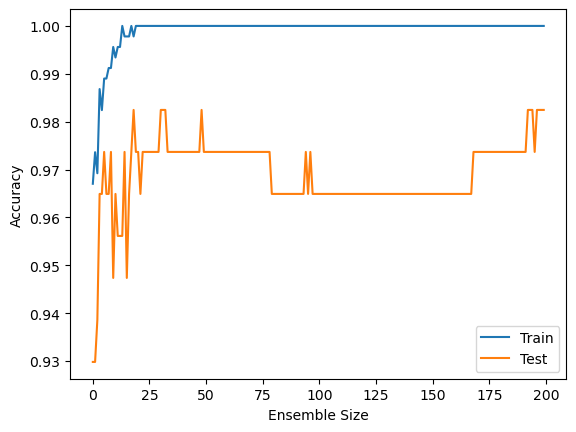

In [18]:
# ---- todo: these curves would look smoother if we were doing a regression problem -----
# ---- todo: curves would look smoother on harder dataset

plt.plot(accuracy_train_cancer_iter)
plt.plot(accuracy_test_cancer_iter)
plt.legend(["Train", "Test"])
plt.ylabel("Accuracy")
plt.xlabel("Ensemble Size");